In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data
import requests
from math import sqrt
import matplotlib.pyplot as plt
from talib import RSI
%matplotlib inline
from talib import RSI, BBANDS,ADX,OBV
import talib as ta


C:\Users\ishan\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:9: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:

portfolio = 1000000  #initial investment
tscost = 0.006      # considering this much transaction cost
nstocks = 0

stock_list = ['BHEL.NS','ITC.NS','LUPIN.NS','RELIANCE.NS','IBVENTURES.NS','HEG.NS','IOC.NS','BPCL.NS','CIPLA.NS','BAJFINANCE.NS','JSWSTEEL.NS','HDFCBANK.NS']  # forming a stock list
for stock in stock_list:
    nstocks+=1         

In [3]:
def readData(ticker, n):
    stocks.append(data.DataReader(ticker, 'yahoo',start='1/1/2015',end='1/1/2019'))   # collecting the data

In [4]:
# getting the technical indicators
i = 0
stocks = []
for ticker in stock_list:
    readData(ticker,i)
    stocks[i]=stocks[i].dropna()
    close =  stocks[i]['Adj Close'].values
    volume=stocks[i]['Volume'].values
    stocks[i]['ema_12']    =  stocks[i]['Adj Close'].ewm(span=12).mean()
    stocks[i]['ema_26']    =  stocks[i]['Adj Close'].ewm(span=26).mean()
    stocks[i]['macd'] = stocks[i]['ema_12'] -stocks[i]['ema_26'] 
    stocks[i]['signal'] = stocks[i]['macd'].ewm(span=9).mean()
    stocks[i]['position']=0
    rsi = RSI(close, timeperiod=14)
    stocks[i]['RSI']=rsi
    up, mid, low = BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    stocks[i]['Bollinger High']=up
    
    stocks[i]['Bollinger Low']=low
    stocks[i]['Bollinger Mid']=mid
    high= stocks[i]['High']
    low= stocks[i]['Low']
    stocks[i]['ADX']=ADX(high,low,close,timeperiod=14)
    stocks[i]['OBV']= OBV(close, volume)
    stocks[i]['MFI']= ta.MFI(high, low, close, volume, timeperiod=14)
    

    

    i=i+1

In [5]:
#Using macd and and bolidger bands
# not  considering shorting
def Strategy(df1):
  
 
    for row in range(len(df1)):
        if(df1['position'].iloc[row-1]==0):
            if(df1['macd'].iloc[row-1] < df1['signal'].iloc[row-1]) and (df1['macd'].iloc[row] > df1['signal'].iloc[row]) :
                df1['position'].iloc[row] = 1
            else:
                df1['position'].iloc[row] = 0
            
            
        elif (df1['position'].iloc[row-1]==1):
            if ( df1['Adj Close'].iloc[row] <df1['Bollinger Low'].iloc[row] ) or(df1['macd'].iloc[row] < df1['signal'].iloc[row] and  df1['Adj Close'].iloc[row] > df1['Bollinger High'].iloc[row]  ):
                df1['position'].iloc[row] = 0
            else:
                df1['position'].iloc[row] = 1
    
        

In [6]:
# getting positions for each stock for each day
i=0
for ticker in stock_list:
  
    Strategy(stocks[i])
    
  
    i=i+1

C:\Users\ishan\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
  s = (len(stocks[0]),nstocks) 
weights = np.zeros(s)      

In [8]:
######## Calculate returns
# Divinding the investment equaly between stocks with a buy position everyday
i = 0
stocks[0]['portfolio']=0
s = (len(stocks[0]),nstocks) 
weights = np.zeros(s)  
stocks[0]['portfolio'].iloc[0]=1000000

for i in range(nstocks):
    stocks[i]['Market Return'] = (stocks[i]['Adj Close'] - stocks[i]['Adj Close'].shift(1)) #Absolute market return
    
stocks[0]['Strategy Return']=0
for row in range(len(stocks[0])-1):
    i = 0
    
    sumwts = 0
    for i in range(nstocks):
        sumwts+=np.abs(stocks[i]['position'].iloc[row])
    for i in range(nstocks):
        if sumwts>0:
            weights[row][i]=( stocks[0]['portfolio'].iloc[row]*stocks[i]['position'].iloc[row])/((sumwts*stocks[i]['Adj Close'].iloc[row])*(1+tscost))
        else:
            weights[row][i]=0
        stocks[0]['Strategy Return'].iloc[row+1]+=stocks[i]['Market Return'].iloc[row+1] * weights[row][i]    
   
    stocks[0]['portfolio'].iloc[row+1]=stocks[0]['portfolio'].iloc[row]+stocks[0]['Strategy Return'].iloc[row+1]

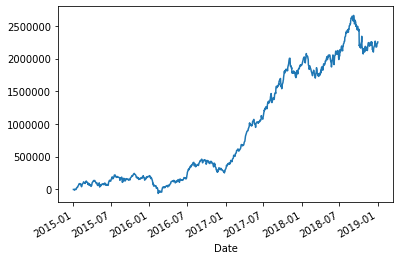

In [9]:
stocks[0]['Strategy Return'].cumsum().plot()

In [10]:
# percentage profits
((stocks[0]['portfolio'][-1]/stocks[0]['portfolio'][0])-1)*100

225.41516836049755

In [11]:
#cagr
stocks[0]['pct Strategy Return']=stocks[0]['portfolio'].pct_change()
n=len(stocks[0])/252
cagr=((((1+stocks[0]['pct Strategy Return']).cumprod()[-1])**(1/n))-1)
cagr

0.3515595360391248

In [12]:
#  yearly volatilty
volatilaty=stocks[0]['pct Strategy Return'].std()*(252**0.5)
volatilaty

0.18338789361320545

In [13]:
#sharpe
sharpe=(cagr-(0.05))/(volatilaty)
sharpe



1.644380826332857

In [14]:
#sortino
neg_volatilaty=stocks[0]['pct Strategy Return'][stocks[0]['pct Strategy Return']<0].std()*(252**0.5)
sortino=(cagr-(0.05))/(neg_volatilaty)
sortino

2.16718275696062

In [15]:
import random